In [1]:
from itertools import cycle
import re

import warnings
import datetime
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,auc,log_loss,roc_curve,roc_auc_score



# From here the code is obtained from the Quevico AI

In [2]:
#Setting up the notebook’s plots
warnings.filterwarnings("ignore")
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])


## Data Preprocessing

In [3]:
train_path = 'train.csv'
test_path = 'test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

df = pd.concat([train_df,test_df])
print(train_df.shape,test_df.shape)

df['arrival_date'] = pd.to_datetime(df['arrival_date'])


(108785, 27) (10099, 26)


In [4]:
#Keep the numeric variables and character string (category) variables in the form of a list
num_features = ["lead_time",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies", "previous_cancellations",
                "previous_bookings_not_canceled","agent","company","days_in_waiting_list",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["hotel","meal","market_segment", "is_repeated_guest",
                "distribution_channel","reserved_room_type","customer_type"]

features = num_features + cat_features

In [5]:
#Convert the category variables into numerals
le = LabelEncoder()
le_dict = {}
for col in cat_features:
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])
    le_dict['col']=le

#Convert into category-types
train_df[cat_features] = train_df[cat_features].astype('category')
test_df[cat_features] = test_df[cat_features].astype('category')

In [6]:
#Separate the explanatory variables and objective variables
train_y = train_df["is_canceled"]
train_X = train_df.drop(["is_canceled",'arrival_date'], axis=1)[features]

test_X = test_df.drop(['arrival_date'], axis=1)[features]

In [7]:
# Convert dataframe into numpy.array
train_X_arr = train_X.values
test_X_arr = test_X.values

# Our own code starts from here to the end

## Data Exploration

In [8]:
#Check for NAs
print(train_df.isnull().values.any())
print(test_df.isnull().values.any())

False
False


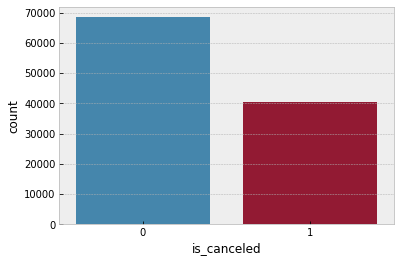

In [9]:
# class distribution
ax = sns.countplot(x="is_canceled", data = train_df)

In [11]:
# #small multiples of numeric features

# plot_features = num_features + ['is_canceled']
# df_pairplot = train_df[plot_features]
# sns.pairplot(df_pairplot, corner=True, hue="is_canceled")


In [12]:
# Check individual numeric feature
train_df[num_features].describe()

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,agent,company,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,adr
count,108785.000000,108785.000000,108785.000000,108785.000000,108785.000000,108785.000000,108785.000000,108785.000000,108785.000000,108785.000000,108785.000000,108785.000000,108785.000000,108785.000000
mean,100.159847,0.909445,2.464935,1.845264,0.092375,0.007951,0.094406,0.136958,73.228892,11.422411,2.540249,0.063097,0.544239,97.085407
std,104.953130,0.992503,1.887034,0.582494,0.377309,0.098157,0.881879,1.448224,106.042608,55.208098,18.401511,0.246518,0.777150,46.910659
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000
25%,17.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,66.500000
50%,65.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,90.000000
75%,152.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,142.000000,0.000000,0.000000,0.000000,1.000000,120.000000
max,737.000000,19.000000,50.000000,55.000000,10.000000,10.000000,26.000000,67.000000,535.000000,539.000000,391.000000,8.000000,5.000000,5400.000000


1. There are negative average daily rate (adr) and crazy amount of 5400
2. For lead time = 0, customer probably arrive at the same date. Should be much less likely to cancel, and there are crazy lengthy period like 737. Wondering what happened there. 
3. Stays_in_weekend_nights positively correlated with stays_in_week_nights. Not surprising. Need to check whether there are cases where both are 0. If so would mean canceled for sure.
4. Number of adults = 0 would be weird. Need to check for such outliers. Same for babies = 10
5. Can form a ratio of previous canceled/previous not canceled
6. Can check for agent, company, customer outliers
7. Can check number of guests vs. number of parking spaces and find outliers

In [13]:
# 1. adr outliers
train_df[train_df.adr<0]

,id,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,arrival_date
61412,61413,1,0,195,4,6,2,0.0,0,0,GBR,4,1,1,0,2,0,H,2,273.0,0.0,0,3,-6.38,0,0,2017-03-05


Didn't cancel. Resort Hotel. Booked 195 days prior to move-in. Transient-Party. Reservation details changed twice. Still have no idea what the negative means here. Can leave it out since there's only one record.

In [14]:
train_df[(train_df.booking_changes>0) & (train_df.assigned_room_type == 'H')]

,id,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,arrival_date
200,201,1,0,0,0,2,3,0.0,0,0,PRT,3,1,0,0,0,7,H,1,0.0,0.0,0,2,192.0,1,0,2017-06-01
358,359,1,0,14,0,2,2,0.0,0,0,PRT,3,1,0,0,0,0,H,1,0.0,0.0,0,2,80.1,0,0,2015-09-17
362,363,1,0,132,2,4,2,2.0,0,0,GBR,3,1,0,0,0,7,H,2,250.0,0.0,0,2,106.3,1,0,2016-05-25
582,583,1,0,103,2,5,2,2.0,0,0,NLD,4,3,0,0,0,2,H,7,95.0,0.0,0,3,72.0,0,0,2016-05-01
603,604,1,0,42,2,5,2,0.0,0,0,BEL,6,3,0,0,0,7,H,1,240.0,0.0,0,2,230.0,0,0,2017-06-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105894,105895,1,0,0,2,1,3,0.0,0,0,AUS,3,1,0,0,0,7,H,2,0.0,0.0,0,2,116.0,1,0,2016-11-13
107720,107721,1,1,0,0,1,3,1.0,0,0,PRT,6,3,0,0,0,7,H,1,240.0,0.0,0,2,115.0,0,0,2015-12-25
107798,107799,1,0,1,0,1,2,2.0,0,2,ESP,6,3,0,0,0,7,H,1,240.0,0.0,0,2,223.0,1,0,2017-04-08
108119,108120,1,0,42,0,5,2,1.0,0,0,ESP,3,1,0,0,0,7,H,3,250.0,0.0,0,2,114.0,1,0,2015-11-10


In [15]:
# 2. order canceled on the same date it was reserved
lead_time_zero = train_df[train_df.lead_time==0]
cancel_same_day = train_df[(train_df.lead_time==0) & (train_df.is_canceled==1)]
print(cancel_same_day.shape,lead_time_zero.shape)

(382, 27) (5936, 27)


Compared to the total number of records with lead_time = 0, those that canceled are much less than those who didn't

In [16]:
# 3. stays_in_weekend_nights = 0 and stays_in_week_nights = 0
train_df[(train_df.stays_in_weekend_nights==0) & (train_df.stays_in_week_nights==0) & (train_df.is_canceled==1)]

,id,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,arrival_date
8627,8628,1,1,7,0,0,1,0.0,0,0,PRT,6,3,0,0,0,0,A,0,339.0,0.0,0,2,0.0,0,0,2016-06-21
8886,8887,0,1,65,0,0,2,0.0,0,0,ARG,6,3,0,0,0,0,B,2,9.0,0.0,0,2,0.0,0,0,2016-03-23
10004,10005,0,1,0,0,0,1,0.0,0,0,FRA,2,0,0,0,0,4,A,1,0.0,450.0,0,2,0.0,0,0,2017-05-08
14254,14255,1,1,6,0,0,2,0.0,0,0,PRT,3,1,0,0,0,2,I,0,250.0,0.0,0,2,0.0,0,0,2016-05-29
15821,15822,0,1,11,0,0,2,0.0,0,3,POL,6,3,0,0,0,0,A,0,9.0,0.0,0,2,0.0,0,1,2016-01-22
21943,21944,1,1,73,0,0,1,0.0,0,0,BEL,2,0,0,0,0,0,D,0,0.0,370.0,0,3,0.0,0,0,2016-04-12
24813,24814,0,1,1,0,0,1,0.0,0,0,AUT,0,0,1,0,1,0,A,0,0.0,153.0,0,2,0.0,0,1,2017-02-01
25304,25305,1,1,123,0,0,2,0.0,0,0,PRT,6,3,0,0,0,0,A,0,240.0,0.0,0,2,0.0,0,1,2016-07-01
32902,32903,0,1,1,0,0,2,0.0,0,0,PRT,1,1,0,0,0,0,A,0,0.0,45.0,0,2,0.0,0,0,2016-09-05
39718,39719,0,1,33,0,0,2,0.0,0,3,GBR,6,3,0,0,0,0,A,0,9.0,0.0,0,2,0.0,0,1,2016-02-20


Question: How were these reservations still not canceled when both weekend_nights and week_nights = 0 and adr = 0?

In [17]:
# 4. adults = 0 and babies = 10
train_df[train_df.adults==0]

,id,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,arrival_date
259,260,0,1,22,1,4,0,2.0,1,0,PRT,3,1,0,0,0,1,B,1,14.0,0.0,0,2,80.75,0,1,2015-12-09
504,505,0,0,109,2,4,0,1.0,0,0,BEL,6,3,0,0,0,1,B,1,9.0,0.0,0,2,73.74,0,1,2016-04-01
706,707,0,0,178,1,1,0,2.0,0,0,DEU,6,3,0,0,0,1,B,0,9.0,0.0,0,3,88.77,0,0,2016-08-27
1584,1585,0,0,193,0,1,0,2.0,0,0,CHE,6,3,0,0,0,1,A,0,9.0,0.0,0,3,86.50,0,0,2016-07-15
1671,1672,0,0,70,0,4,0,3.0,0,0,PRT,5,3,0,0,0,1,B,0,20.0,0.0,0,3,9.00,0,1,2016-04-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104190,104191,0,0,46,2,3,0,1.0,0,0,PRT,3,1,0,0,0,1,B,0,14.0,0.0,0,2,63.12,0,0,2016-02-07
104268,104269,0,0,40,1,3,0,2.0,0,0,KOR,3,1,0,0,0,1,B,0,14.0,0.0,0,3,67.15,0,0,2016-02-11
104805,104806,0,1,150,1,3,0,2.0,0,0,PRT,6,3,0,1,0,1,B,0,8.0,0.0,0,3,6.00,0,1,2016-03-24
106068,106069,0,0,28,0,1,0,2.0,0,3,DEU,6,3,0,0,0,0,A,1,9.0,0.0,0,3,109.00,0,2,2017-06-13


In [18]:
train_df[(train_df.adults==0) & (train_df.required_car_parking_spaces > 0)]

,id,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,arrival_date
19050,19051,0,0,0,0,1,0,2.0,0,0,FRA,6,3,0,0,0,5,B,0,9.0,0.0,0,3,6.0,1,0,2016-04-08
67485,67486,0,0,16,2,2,0,2.0,0,0,PRT,3,1,0,0,0,1,B,1,0.0,0.0,0,3,6.0,1,1,2017-01-20


In France, the legal age to drive is 18 and legal adult age is also 18. How are those still counted as children not adults? 

In [19]:
train_df[(train_df.adults==0) & (train_df.babies>0)]

,id,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,arrival_date
259,260,0,1,22,1,4,0,2.0,1,0,PRT,3,1,0,0,0,1,B,1,14.0,0.0,0,2,80.75,0,1,2015-12-09
44725,44726,0,0,14,0,3,0,2.0,1,0,ITA,6,3,0,0,0,1,B,2,9.0,0.0,0,2,116.49,0,2,2016-06-09
97470,97471,0,0,6,0,1,0,2.0,1,0,PRT,6,3,0,0,0,1,B,0,9.0,0.0,0,3,77.00,0,2,2015-12-18


How are there children with babies??

Only explanation that makes sense here is that the parents booked the hotel for their children while they are off somewhere else.

In [20]:
#6. Check for agents/company that has most cancel rate

agents_cancel_sum = pd.DataFrame(train_df.groupby(['agent'])['is_canceled'].agg('sum').reset_index())
agents_cancel_rate = pd.DataFrame(train_df.groupby(['agent'])['is_canceled'].agg('mean').reset_index())
agents_cancel = pd.merge(agents_cancel_sum, agents_cancel_rate, on='agent')
agents_cancel = agents_cancel.sort_values(by=['is_canceled_x'],ascending = False)

agents_cancel

,agent,is_canceled_x,is_canceled_y
9,9.0,11481,0.409509
1,1.0,5279,0.734521
174,240.0,4606,0.375020
0,0.0,3785,0.243722
6,6.0,966,0.329131
...,...,...,...
208,288.0,0,0.000000
209,289.0,0,0.000000
212,294.0,0,0.000000
213,295.0,0,0.000000


Seems like agent 9 has a lot of canceled reservations. Still doesn't really stand out as that much of an outlier in terms of cancellation rate.

,id,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,arrival_date
31474,31475,1,0,138,2,2,2,0.0,0,2,AUT,3,0,1,0,2,4,F,1,0.0,0.0,122,3,80.0,8,0,2017-03-19
65720,65721,1,0,26,0,5,2,0.0,0,2,AUT,3,0,1,0,2,4,I,1,0.0,0.0,0,3,40.0,8,1,2017-03-14


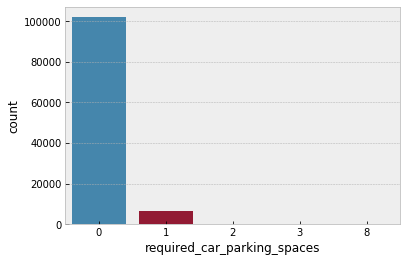

In [21]:
#7. Other Outlier checking
ax = sns.countplot(x="required_car_parking_spaces", data=train_df)
train_df[(train_df.required_car_parking_spaces==8)]

2 adults with no children required 8 parking spaces...kinda weird. Same agent and company booked this. Maybe they are rich with many cars? Or holding an event there? 

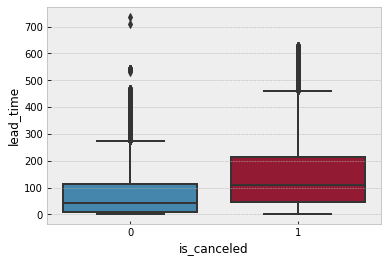

In [22]:
#Analyzing lead time differences

ax1 = sns.boxplot(x="is_canceled", y="lead_time", data=train_df)

The more lead time, the more likely it is getting canceled

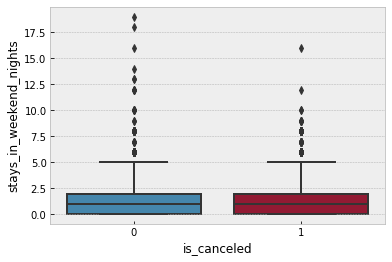

In [23]:
ax1 = sns.boxplot(x="is_canceled", y="stays_in_weekend_nights", data=train_df)

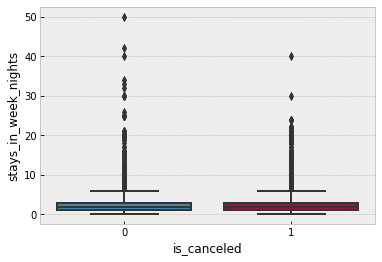

In [24]:
ax1 = sns.boxplot(x="is_canceled", y="stays_in_week_nights", data=train_df)

The above two variables doesn't contribute much to cancellation

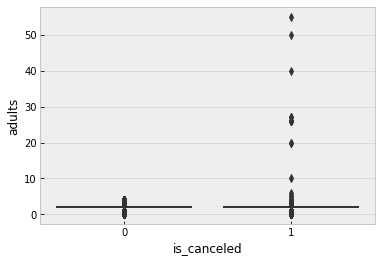

In [25]:
ax1 = sns.boxplot(x="is_canceled", y="adults", data=train_df)

For cancellations, there tend to be more outliers when it comes to number of adults

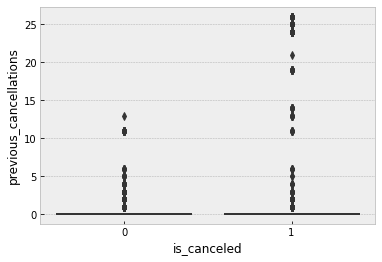

In [26]:
ax1 = sns.boxplot(x="is_canceled", y="previous_cancellations", data=train_df)

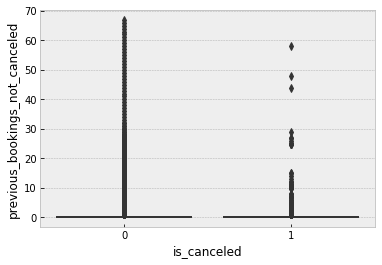

In [27]:
ax1 = sns.boxplot(x="is_canceled", y="previous_bookings_not_canceled", data=train_df)

Same for previous cancellations and previous_bookings_not_canceled

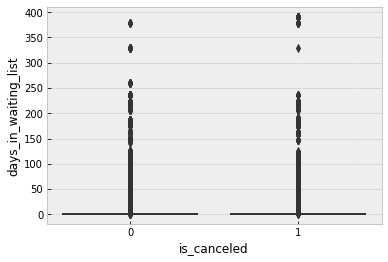

In [28]:
ax1 = sns.boxplot(x="is_canceled", y="days_in_waiting_list", data=train_df)

waiting list doesn't intefere with cancellation much

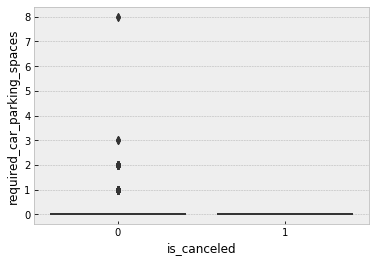

In [29]:
ax1 = sns.boxplot(x="is_canceled", y="required_car_parking_spaces", data=train_df)

Seems like those who requested car parking are likely to not cancel.

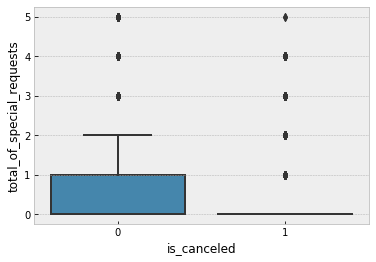

In [30]:
ax1 = sns.boxplot(x="is_canceled", y="total_of_special_requests",data=train_df)

Seems like those who didn't cancel may have more '1-special-request' than those who did

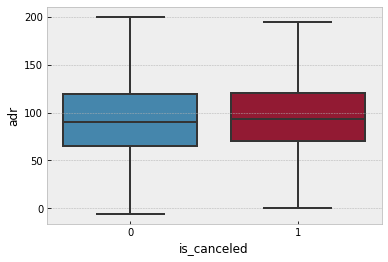

In [33]:
ax1 = sns.boxplot(x="is_canceled", y="adr",data=train_df, showfliers = False)

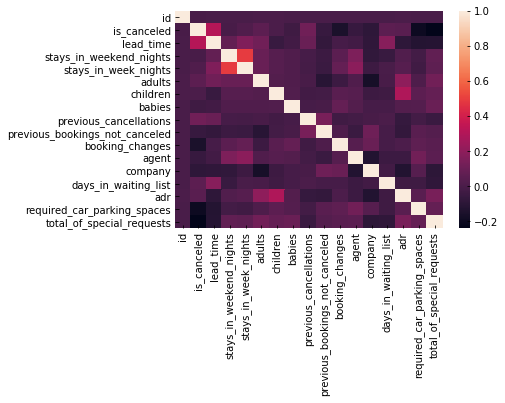

In [35]:
corr = train_df.corr()
sns.heatmap(corr)

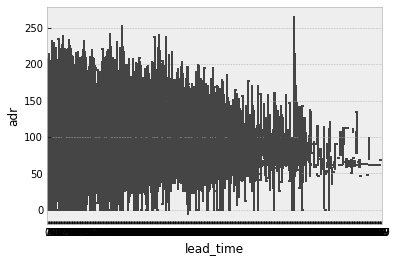

In [36]:
ax3 = sns.boxplot(x="lead_time", y="adr",data=train_df, showfliers = False)

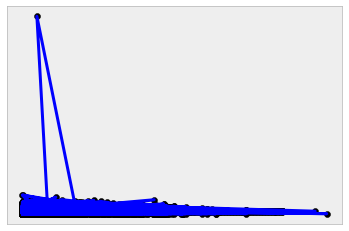

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

#
# Plot outputs
plt.scatter(train_df.lead_time, train_df.adr,  color='black')
plt.plot(train_df.lead_time, train_df.adr, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()